# Install

Listado de paquetes necesarios:
1. matplotlib-venn instalado. Si no está en tu entorno, ejecuta: poetry add matplotlib-venn.

# Funciones Auxiliares

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [148]:
def how_many_times_item_sold(variant_id: object, orders: pd.DataFrame) -> int:
    all_items = [item for sublist in orders['ordered_items'] for item in sublist]
    item_counts = Counter(all_items)
    item_freq_df = pd.DataFrame(item_counts.items(), columns=['variant_id', 'count']).sort_values(by='count', ascending=False)
    item_freq_df['variant_id'] = item_freq_df['variant_id'].astype(str)
    return item_freq_df[item_freq_df['variant_id'] == str(variant_id)]['count'].values[0] if not item_freq_df[item_freq_df['variant_id'] == str(variant_id)].empty else 0
        

In [ ]:

def nulos_y_duplicados(df: pd.DataFrame) -> None:
    print(df.isnull().mean() * 100)
    cols_validas = [col for col in df.columns if not df[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any()]
    print(f"Hay {df.duplicated(subset=cols_validas).sum()} filas duplicadas.")
    


# Dataframes
Se importan los archivos Parquet a dataframes.

In [ ]:
import pandas as pd
import os

# Carpeta con los archivos parquet
data_dir = '/home/nachotunon/zrive-ds/data/interim/groceries/sampled-datasets'


# Listar archivos .parquet
parquet_files = [f for f in os.listdir(data_dir) if f.endswith('.parquet')]

# Cargar cada archivo en una variable con su nombre base
for fname in parquet_files:
    var_name = os.path.splitext(fname)[0]      # p.ej. 'transactions' de 'transactions.parquet'
    path = os.path.join(data_dir, fname)
    
    # Crear la variable dinámica
    globals()[var_name] = pd.read_parquet(path)
    
    # Confirmación rápida
    print(f"{var_name} cargado: {globals()[var_name].shape}")


inventory cargado: (1733, 6)
orders cargado: (8773, 6)
regulars cargado: (18105, 3)
users cargado: (4983, 10)
abandoned_carts cargado: (5457, 4)


Ahora tenemos guardado un df con el mismo nombre que el archivo PARQUET raw que obtuvimos. No podemos todavía asegurar el número de clientes, productos o pedidos sin evaluar los datos, sin saber si existen duplicados o errores. 

Vamos a analizar cada df por separados para intentar realizar los siguientes puntos: 
1. Comprender las variables.
2. Examinar los datos, ver si hay errores o missings. 

Finalmente, tras analizar los df y realizar los checks adecuados o corregir lo necesario, trataremos de:
1. Responder a preguntas para comprender mejor el problema.
2. Realizar hipótesis. 
3. Fusionar o manipular los datos de forma adecuada.
4. Plantear posibles problemas de negocio.


# Orders
Se sigue el esquema de análisis planteado anteriormente. Vamos a ver qué hay en la tabla de orders.



## Estructura Tabla


In [47]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8773 entries, 10 to 64538
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              8773 non-null   int64         
 1   user_id         8773 non-null   object        
 2   created_at      8773 non-null   datetime64[us]
 3   order_date      8773 non-null   datetime64[us]
 4   user_order_seq  8773 non-null   int64         
 5   ordered_items   8773 non-null   object        
dtypes: datetime64[us](2), int64(2), object(2)
memory usage: 479.8+ KB


 Se observa que la tabla orders tiene 6 columnas:
- id: id de la orden
- user_id: id del cliente (user)
- created_at: cuándo se creó la orden
- order_date: cuándo se pidió la orden
- user_order_seq: número de pedido de ese usuario históricamente 
- ordered_items: listado de pedidos



## Errores o Missings en los Datos

In [ ]:
nulos_y_duplicados(orders)

id                0.0
user_id           0.0
created_at        0.0
order_date        0.0
user_order_seq    0.0
ordered_items     0.0
dtype: float64
Hay 0 filas duplicadas


Se aprecia que no hay missings, y a priori, no hay duplicados. Tendría sentido ahora analizar valores atípicos. Es difícil comprobar si un id o un user_id está mal pues no sabemos cómo se crean esos números id. Podemos ver también si hay alguna fecha que no tenga sentido, o algún usuario con muchísimos pedidos. 

Para comprobar si user_order_seq está bien, se puede filtrar por cada usuario el df, y mirar si el vector de user_order_seq coincide con range(1, número de filas del df filtrado + 1 ).

Para la columna de ordered_items, se pueden extraer todos los id de pedidos y comprobar que realmente están en el df inventory.

In [82]:
orders.describe().T

,count,mean,min,25%,50%,75%,max,std
id,8773.0,3684683902139.209473,2204073066628.0,3690254696580.0,3846691520644.0,3945085567108.0,4026732413060.0,414543651600.97345
created_at,8773,2021-08-22 03:54:18.750028,2020-04-30 14:32:19,2021-04-25 11:50:37,2021-10-11 11:29:44,2022-01-03 18:14:23,2022-03-14 00:24:59,NaN
order_date,8773,2021-08-21 12:47:21.262966,2020-04-30 00:00:00,2021-04-25 00:00:00,2021-10-11 00:00:00,2022-01-03 00:00:00,2022-03-14 00:00:00,NaN
user_order_seq,8773.0,2.445116,1.0,1.0,1.0,3.0,25.0,2.707693


Parece que los resultados obtenidos tienen sentido, ninguna fecha es disparatada, ni tampoco id ni user_order_seq. Vamos a comprobar que esta columna está bien. 

In [83]:
def check_user_order_seq(df: pd.DataFrame):
    """
    Check if user_order_seq == [1,2,...,n] for each user.
    """
    def is_exact_seq(x):
        seq = x.tolist()
        return seq == list(range(1, len(seq)+1))
    
    return df.groupby('user_id')['user_order_seq'].apply(is_exact_seq)

seq_status=check_user_order_seq(orders)
num_false = (~seq_status).sum()
print(f"Number of users with non-sequential orders: {num_false}")

Number of users with non-sequential orders: 0


Veamos si existe algún pedido fuera del df inventory.

In [84]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB


Unique items in orders: 2117
Unique items in inventory: 1733
Number of items in orders not in inventory: 640


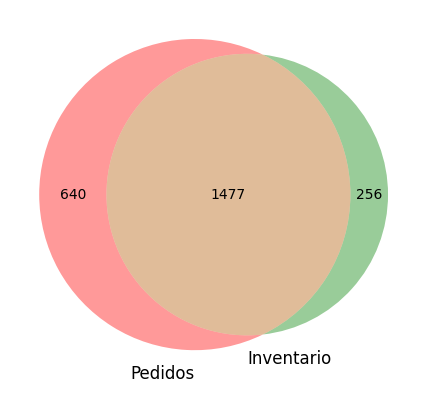

In [123]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def items_in_inventory(df: pd.DataFrame, inventory: pd.DataFrame):
    """
    Check if all items in the order (which are in a list) are in the inventory.
    """
    unique_ordered = set(item for sublist in df['ordered_items'] for item in sublist)
    print(f"Unique items in orders: {len(unique_ordered)}")
    inventory_ids = set(inventory['variant_id'].unique())
    print(f"Unique items in inventory: {len(inventory_ids)}")
    missing = unique_ordered - inventory_ids
    return unique_ordered, inventory_ids, missing
    
unique_ordered, inventory_ids, missing = items_in_inventory(orders, inventory)
print(f"Number of items in orders not in inventory: {len(missing)}")

# Diagrama de Venn
size_A = len(unique_ordered)    # Tamaño de A
size_B = len(inventory_ids)   # Tamaño de B
size_intersection = len(unique_ordered)-len(missing)  # Tamaño de A/B (intersección entre A y B)
size_A_only = size_A - size_intersection
size_B_only = size_B - size_intersection
venn2(subsets=(size_A_only, size_B_only, size_intersection), set_labels=('Pedidos', 'Inventario'))
plt.show()

A priori, y salvo algún error en el código, parece ser que hay items que se pidieron que ya no están en el inventario. Esto puede implicar la existencia de items (productos) descatalogados o que ya no se comercian.

In [118]:
missing_df = pd.DataFrame(sorted(missing), columns=["variant_id_no_en_inventory"])
missing_df.to_csv("data/interim/groceries/missing_variant_ids.csv", index=False)

Vamos a realizar lo mismo con los users. 

In [127]:
unique_user_ids = set(orders['user_id'].unique())
print(f"Unique user IDs in orders: {len(unique_user_ids)}")
unique_user_ids_inventory = set(users['user_id'].unique())
print(f"Unique user IDs in inventory: {len(unique_user_ids_inventory)}")
missing_user_ids = unique_user_ids - unique_user_ids_inventory
print(f"Number of user IDs in orders not in inventory: {len(missing_user_ids)}")


Unique user IDs in orders: 4983
Unique user IDs in inventory: 4983
Number of user IDs in orders not in inventory: 0


Por último, vamos a ver cuántos productos (contando todos, no unique) se han vendido.

In [180]:
total_products_ordered = orders['ordered_items'].apply(lambda x: len(x)).sum()
print(f"Total products ordered: {total_products_ordered}")

Total products ordered: 107958


## Conclusions

1. Tamaño: Hay 6 columnas (id, user_id, created_at, order_date, user_order_seq, ordered_items) y 8773 registros de pedidos.
2. No parece haber errores de duplicados, ni hay missings, ni ningún error sustancial en el dataframe.
3. Se han pedido 2117 productos distintos, de un inventario de 1733. Hay 640 productos vendidos sin catalogar en el inventario, y hay 256 productos del inventario que nunca se han pedido.
4. Todos los 4983 usuarios que compraron están registrados en users con su user_id. 
5. La mayoría de clientes han pedido solo una vez, el que más ha pedido ha sido 25. Posible problema a la hora de captar clientes recurrentes. Explorar los motivos.
6. Se registran datos desde el 30 de abril de 2020 hasta el 3 de enero de 2022.
7. De los 8773 registros de pedidos, se han vendido 107958 productos totales, correspondientes a 2117 productos diferentes.


Queda pendiente por analizar qué productos se venden más, usuarios que más usan, cuota de captación de clientes... Se explorará todo en la sección de preguntas.

# Inventory

## Estructura Tabla

In [128]:
inventory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1733 entries, 0 to 1732
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   variant_id        1733 non-null   int64  
 1   price             1733 non-null   float64
 2   compare_at_price  1733 non-null   float64
 3   vendor            1733 non-null   object 
 4   product_type      1733 non-null   object 
 5   tags              1733 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 81.4+ KB


In [129]:
inventory.head()

,variant_id,price,compare_at_price,vendor,product_type,tags
0,39587297165444,3.09,3.15,heinz,condiments-dressings,"[table-sauces, vegan]"
1,34370361229444,4.99,5.50,whogivesacrap,toilet-roll-kitchen-roll-tissue,"[b-corp, eco, toilet-rolls]"
2,34284951863428,3.69,3.99,plenty,toilet-roll-kitchen-roll-tissue,[kitchen-roll]
3,33667283583108,1.79,1.99,thecheekypanda,toilet-roll-kitchen-roll-tissue,"[b-corp, cruelty-free, eco, tissue, vegan]"
4,33803537973380,1.99,2.09,colgate,dental,[dental-accessories]


Hay 1733 productos en el inventario. Las columnas o variables son las siguientes (son 6 en total): 
1. variant_id: id de producto
2. price: precio de producto
3. compare_at_price: precio para comparar (mostrar un descuento)
4. vendor: vendedor
5. product_type: tipo de producto
6. tags: tags o etiquetas en los que se encuadra el producto (vegano, eco, accesorios dentales...)

## Errores o Missings en los Datos

In [156]:
import numpy as np

for col in inventory.columns:
    if inventory[col].apply(lambda x: isinstance(x, str)).any():
        inventory[col] = inventory[col].replace("", np.nan)


In [157]:
import numpy as np
print(inventory.isnull().mean() * 100)
cols_validas = [col for col in inventory.columns if not inventory[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any()]
print(inventory.duplicated(subset=cols_validas).sum())
print(inventory.isnull().sum())

variant_id          0.000000
price               0.000000
compare_at_price    0.000000
vendor              0.000000
product_type        0.230814
tags                0.000000
dtype: float64
0
variant_id          0
price               0
compare_at_price    0
vendor              0
product_type        4
tags                0
dtype: int64


In [158]:
inventory.describe().T

,count,mean,std,min,25%,50%,75%,max
variant_id,1733.0,3.694880e+13,2.725674e+12,3.361529e+13,3.427657e+13,3.927260e+13,3.948318e+13,4.016793e+13
price,1733.0,6.307351e+00,7.107218e+00,0.000000e+00,2.490000e+00,3.990000e+00,7.490000e+00,5.999000e+01
compare_at_price,1733.0,7.028881e+00,7.660542e+00,0.000000e+00,2.850000e+00,4.490000e+00,8.210000e+00,6.000000e+01


No hay ni duplicados. Los missings se han marcado con NaN en las columnas con strings. Los valores numéricos parecen razonables. El precio más barato es 0 (gratis), habría que analizar los motivos y las causas. El más caro es 59,99 (unidades monetarias, por ejemplo, dólares). Vamos a analizar cuántos hay con precio 0, porque además el compare_at_price mínimo también es 0.

In [159]:
inventory_0 = inventory[inventory["price"] == 0]
len(inventory_0)

71

Son 71 productos con precio 0, que podríamos considerar como que los missings se imputan a 0. Estudiaremos más adelante qué hacer con estos 71 productos de los 1733 que hay. Vamos a hacer un análisis previo simple: 
1. Ver los que se vendieron y los que no. 
2. Ver cuánto se vendieron los que sí.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import numpy as np

sales_count = []


for item in inventory_0["variant_id"]:
    count = how_many_times_item_sold(item, orders)
    sales_count.append(count)

sales_df = pd.DataFrame({
    'variant_id': inventory_0["variant_id"],
    'sales_count': sales_count
})

sales_df = sales_df.sort_values(by='sales_count', ascending=True)
print(sales_df.head())


          variant_id  sales_count
95    40070658490500            0
1250  40070660030596            0
1243  40070658261124            0
1157  40070659408004            0
1149  40070658359428            0


In [161]:
inventory.iloc[96]

variant_id          40167931674756
price                          0.0
compare_at_price               0.0
vendor               whogivesacrap
product_type                   NaN
tags                            []
Name: 96, dtype: object

Viendo estas últimas celdas, nos dimos cuenta que hay "" que no cuenta como missing. En ese caso hemos vuelto atrás y hemos cambiado "" por NaN para tenerlos en cuenta. De esta forma, esos productos que no tienen product_type asociado se verán con NaN. De todas formas, se aprecia que son solo 4. 

Además, concluímos que de los productos con missing type_product ninguno se vendió, por lo que podremos en un futuro descartar estas observaciones o registros si es necesario.

## Conclusions

1. Tamaño: Hay 6 columnas (variant_id, price, compare_at_price, vendor, product_type, tags), y hay 1733 productos en el inventario.
2. No hay duplicados.
3. Los missings analizados, que a priori solo eran en product_type (y tags), pasaron de "" a NaN. Eran 4 en total.
4. El precio mínimo es 0, que se puede considerar missing de precio. En total eran 71 productos, los cuales no se vendieron en orders, por lo que quizás es posible descartarlos en un futuro. 
5. El precio máximo es de 59,99 unidades monetarias.
6. Si se descartan los productos con missing en precio (71 de 1733), restan 1662 productos, lo que cambiaría el diagrama de Venn del análisis anterior del df orders.

# Users

## Estructura Tabla

In [165]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 2160 to 3360
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                4983 non-null   object 
 1   user_segment           4983 non-null   object 
 2   user_nuts1             4932 non-null   object 
 3   first_ordered_at       4983 non-null   object 
 4   customer_cohort_month  4983 non-null   object 
 5   count_people           325 non-null    float64
 6   count_adults           325 non-null    float64
 7   count_children         325 non-null    float64
 8   count_babies           325 non-null    float64
 9   count_pets             325 non-null    float64
dtypes: float64(5), object(5)
memory usage: 428.2+ KB


Hay 4983 usuarios en el dataframe, que se corresponden con todos los que pidieron algo en orders. Hay 10 variables, que son las siguientes: 
1. user_id: id de usuario.
2. user_segment: segmento del usuario.
3. user_nuts1: parece que tiene que ver con indicadores geográficos.
4. first_ordered_at: primera compra fecha.
5. customer_cohort_month: primera compra (día 1 de cada ¿mes?, ¿mes siguiente?).
6. count_people: personas en el hogar.
7. count_adults: adultos en el hogar.
8. count_children: niños en el hogar.
9. count_babies: bebés en el hogar. 
10. count_pets: mascotas en el hogar.

Algunas variables es necesario explorarlas más para comprender su naturaleza. También, quiero que las columnas first_ordered_at y customer_cohort_month, que son fechas pero aparecen como objects, sean del mismo tipo que las fechas de orders.

In [176]:
import pandas as pd
users['first_ordered_at']= pd.to_datetime(users['first_ordered_at'])
users['customer_cohort_month']= pd.to_datetime(users['customer_cohort_month'])

users.to_csv(users.to_csv("../../data/interim/groceries/users.csv", index=False))

',user_id,user_segment,user_nuts1,first_ordered_at,customer_cohort_month,count_people,count_adults,count_children,count_babies,count_pets\n2160,0e823a42e107461379e5b5613b7aa00537a72e1b0eaa7a962aa3d39097d41d37b01d5089f13306c248e66a110da986a44448c007ce8e1052db8d1802f00fbd85,Top Up,UKH,2021-05-08 13:33:49,2021-05-01,,,,,\n1123,15768ced9bed648f745a7aa566a8895f7a73b9a47c1d4f65f3d519b46bc97b938812e4cea840a67b82c9ff349f086af76b5ba8171c0866103b942061d74027b1,Top Up,UKJ,2021-11-17 16:30:20,2021-11-01,,,,,\n1958,33e0cb6eacea0775e34adbaa2c1dec16b9d6484e6b93249db254a5f358ed7c17e47bebe76903b28447ece00be7e266aad036337cdf46ccdd9ab485136d40b85d,Top Up,UKD,2022-03-09 23:12:25,2022-03-01,,,,,\n675,57ca7591dc79825df0cecc4836a58e6062454555c86c354dd736bd34eca7eb4e588c5afea0af0bf3ee41290630bcdc6042b6fae0c19428d887b586a719825bda,Top Up,UKI,2021-04-23 16:29:02,2021-04-01,,,,,\n4694,085d8e598139ce6fc9f75d9de97960fa9e1457b409ec007b214d1039e959eca61c2b5bd6dc5cc09b8147f3581366413cf9ca901906969ba6c152e44ab4cd8fb1,

In [177]:
print(users['user_nuts1'].unique())
print(len(users['user_nuts1'].unique()))
print(users['customer_cohort_month'].unique())

['UKH' 'UKJ' 'UKD' 'UKI' 'UKE' 'UKK' 'UKF' 'UKL' 'UKC' 'UKG' 'UKM' None
 'UKN']
13
<DatetimeArray>
['2021-05-01 00:00:00', '2021-11-01 00:00:00', '2022-03-01 00:00:00',
 '2021-04-01 00:00:00', '2020-12-01 00:00:00', '2021-08-01 00:00:00',
 '2020-11-01 00:00:00', '2022-02-01 00:00:00', '2021-07-01 00:00:00',
 '2021-10-01 00:00:00', '2021-12-01 00:00:00', '2021-06-01 00:00:00',
 '2022-01-01 00:00:00', '2021-02-01 00:00:00', '2020-06-01 00:00:00',
 '2020-10-01 00:00:00', '2021-01-01 00:00:00', '2021-09-01 00:00:00',
 '2021-03-01 00:00:00', '2020-05-01 00:00:00', '2020-09-01 00:00:00',
 '2020-07-01 00:00:00', '2020-08-01 00:00:00', '2020-04-01 00:00:00']
Length: 24, dtype: datetime64[ns]


## Errores o Missings en los Datos

In [168]:
import numpy as np
print(users.isnull().mean() * 100)
cols_validas = [col for col in users.columns if not users[col].apply(lambda x: isinstance(x, (list, np.ndarray))).any()]
print(users.duplicated(subset=cols_validas).sum())


user_id                   0.000000
user_segment              0.000000
user_nuts1                1.023480
first_ordered_at          0.000000
customer_cohort_month     0.000000
count_people             93.477825
count_adults             93.477825
count_children           93.477825
count_babies             93.477825
count_pets               93.477825
dtype: float64
0


Muchos missings en las columnas de count. Tendría sentido imputarlos como 0 si por ejemplo fueran pets, babies... Pero no tiene sentido poner 0 a count_people o count_adults por ejemplo. Queda pendiente qué hacer con esto. 

No hay duplicados.

In [172]:
print(users['user_segment'].unique())

['Top Up' 'Proposition']


In [178]:
users.describe().T

,count,mean,min,25%,50%,75%,max,std
first_ordered_at,4983,2021-08-20 02:41:47.038330368,2020-04-30 14:32:19,2021-04-08 12:55:48.500000,2021-10-26 22:48:14,2022-01-03 12:38:51.500000,2022-03-12 14:48:34,NaN
customer_cohort_month,4983,2021-08-04 22:37:03.720649984,2020-04-01 00:00:00,2021-04-01 00:00:00,2021-10-01 00:00:00,2022-01-01 00:00:00,2022-03-01 00:00:00,NaN
count_people,325.0,2.787692,0.0,2.0,3.0,4.0,8.0,1.365753
count_adults,325.0,2.003077,0.0,2.0,2.0,2.0,7.0,0.869577
count_children,325.0,0.707692,0.0,0.0,0.0,1.0,6.0,1.026246
count_babies,325.0,0.076923,0.0,0.0,0.0,0.0,2.0,0.289086
count_pets,325.0,0.636923,0.0,0.0,0.0,1.0,6.0,0.995603


## Conclusions

1. Tamaño: Hay 4983 usuarios diferentes, que son exactamente el número de clientes que realizaron los pedidos. Las variables son 10: el id, 2 que clasifican al usuario por segmento y localización, 2 de la fecha de incorporación de cliente, y 5 de count. 
2. Las columnas count_ tienen muchos missings, en torno al 93.5%, habría que estudiar qué hacer con ellas en concreto. Algunas tiene sentido imputarlas a 0, otras no. Además, como coincide el número de missings de todas, es razonable pensar que se debe a que el user que no responde a alguna no responde a ninguna, puesto que al ser más común que haya adultos (o gente) en la unidad familiar que mascotas, si los missings fueran 0 habría menos missings en count_people o count_adults que en count_pets. Esto parece suponer que la gente directamente no responde a las preguntas.
3. Hay dos tipos de segmento: Top Up y Proposition. Se puede interpretar por los nombres que el primero es un usario "genuino" y el segundo viene de una promoción o campaña específica. 
4. Hay 12 subconjuntos que suponemos geográficos, siendo un 1% missing del total de clientes. Son los siguientes: ['UKH' 'UKJ' 'UKD' 'UKI' 'UKE' 'UKK' 'UKF' 'UKL' 'UKC' 'UKG' 'UKM' 'UKN'].
5. Las fechas, después de haberlas convertido de object a datetime, coinciden con el intervalo de tiempo de orders (lógico pues no hay clientes que no estén registrados).

# Regulars

## Estructura Tabla

In [181]:
regulars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18105 entries, 3 to 37720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     18105 non-null  object        
 1   variant_id  18105 non-null  int64         
 2   created_at  18105 non-null  datetime64[us]
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 565.8+ KB


Hay 18105 registros con 3 variables:
1. user_id: id de usuario.
2. variant_id: id de producto (integer).
3. created_at: fecha de cuándo se creó. ¿Coincide con otras variables? Sí, hay una en orders que se llama igual.

Según la hoja de deberes, este df son los productos que los clientes quieren comprar. La primera hipótesis de pensar que al haberlo comprado entraba en la lista de deseados se descarta, puesto que vimos en users que se habían pedido cerca de 109k productos diferentes, y este tiene únicamente alrededor de 18k.

## Errores o Missings en los Datos

In [187]:
nulos_y_duplicados(regulars)

user_id       0.0
variant_id    0.0
created_at    0.0
dtype: float64
Hay 123 filas duplicadas


Eliminamos duplicados.

In [198]:
regulars = regulars.drop_duplicates()
regulars.to_csv("../../data/interim/groceries/regulars.csv", index=False)

In [199]:
regulars.describe().T

,count,mean,min,25%,50%,75%,max,std
variant_id,17982.0,35127521864172.125,33615268282500.0,33826433106052.0,34236303835268.0,34488548425860.0,40133621973124.0,2176571796556.130615
created_at,17982,2021-08-16 17:18:52.288121,2020-04-30 13:09:27,2021-03-26 11:44:50,2021-10-18 09:10:50,2022-01-15 08:26:57,2022-03-14 07:49:24,NaN


Hay 1448 usuarios en el dataset de regulars.
El usuario con más apariciones en regulars tiene 726 productos favoritos.


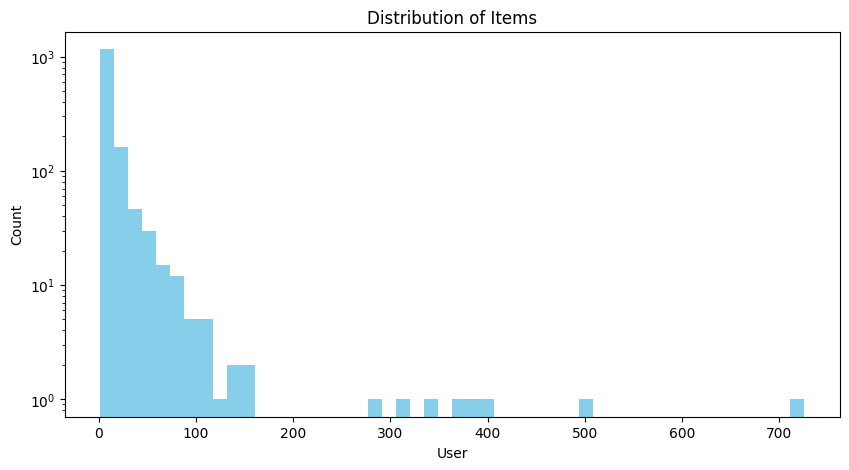

In [197]:
len(regulars['user_id'].unique())
print(f"Hay {len(regulars['user_id'].unique())} usuarios en el dataset de regulars.")
apariciones_regulars = Counter(regulars['user_id'])
print(f"El usuario con más apariciones en regulars tiene {apariciones_regulars.most_common(1)[0][1]} productos favoritos.")

apariciones_regulars = pd.DataFrame(apariciones_regulars.items(), columns=['user', 'count']).sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
plt.hist( apariciones_regulars['count'], bins=50, color='skyblue')
plt.xlabel('User')
plt.ylabel('Count')
plt.yscale("log")
plt.title('Distribution of Items')
plt.show()



Se aprecian varios usuarios con un número inusual de preferencias de productos. A partir de esto, se abren las siguientes opciones de exploración:
1. Sería interesante sacar datos concretos de cuántos usuarios tienen más de n preferencias. 
2. ¿Los productos que más aparecen en regulars son los que más se venden? ¿Hay correlación?
3. ¿Los usuarios que más preferencias tienen son los que más compran? 
4. ¿Cuál es el porcentaje de comprados/regulares por persona? Es decir, marcando como binario si se compró o no, ¿cuál es la media del ratio comprados/regulares?
De momento, y como no tenemos preguntas de negocio que responder, quedan marcadas como posibles siguientes pasos.

## Conclusions


1. Tamaño: Hay 18105 registros, y 3 columnas (user_id, variant_id, created_at). El dataframe muestra los preferidos o "regulares" de uno en uno de los usuarios. Hay 123 duplicados, por lo que finalmente se tienen 17982 registros.
2. No parece haber valores missings salvo error de análisis.
3. La primera fecha corresponde al día del primer pedido (30 de abril de 2020), pero la última corresponde a una fecha posterior al último pedido que se tiene constancia en el df orders.
4. Hay 1448 usuarios que tienen puestas sus preferencias. De esos, es de destacar algunos con más de 250 preferencias, teniendo el que más 726 productos favoritos.
5. Siguientes pasos a estudiar:
A. Sería interesante sacar datos concretos de cuántos usuarios tienen más de n preferencias. 
B. ¿Los productos que más aparecen en regulars son los que más se venden? ¿Hay correlación?
C. ¿Los usuarios que más preferencias tienen son los que más compran? 
D. ¿Cuál es el porcentaje de comprados/regulares por persona? Es decir, marcando como binario si se compró o no, ¿cuál es la media del ratio comprados/regulares?

# Abandoned Carts

## Estructura Tabla

In [201]:
abandoned_carts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5457 entries, 0 to 70050
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          5457 non-null   int64         
 1   user_id     5457 non-null   object        
 2   created_at  5457 non-null   datetime64[us]
 3   variant_id  5457 non-null   object        
dtypes: datetime64[us](1), int64(1), object(2)
memory usage: 213.2+ KB


Hay 5457 carritos abandonados. A priori, se me ocurren dos interpretaciones posibles: 
1. En un momento concreto, hay 5457 carritos que no se han llegado a procesar (fecha posterior a la última). 
2. A lo largo del tiempo, se registran los carritos que no se han llegado a procesar, pero se han descartado posteriormente. 


Imaginemos el siguiente caso: 

Alguien rellena el carrito, lo deja x días (un mes, por ejemplo) y lo compra al cabo de ese tiempo. ¿Es carrito abandonado o no? Con la primera interpretación, si el momento fijado es previo a que procese (y posterior a crear el carrito, obviamente), entonces sí es abandonado. Con la segunda, no, puesto que no sabríamos si se va a llegar a completar o no.
Si ese tiempo fuese de dos años, suponiendo que la probabilidad de compra es muy baja, ¿sigue siendo abandonado? 

Tiene más sentido la segunda interpretación, que implica un descarte del carrito. Entonces, ¿qué sucede con aquellos que quedan pendientes? Según esta interpretación, no se contabilizan. 

Existen 4 variables en este df: 
1. id: id order.
2. user_id: id user.
3. created_at: fecha de creación. 
4. variant_id: listado de pedidos. 

Viendo las variables, una manera de comprobar las dos interpretaciones es ver si hay algún pedido de abandoned_carts en orders, lo que implicaría que está contabilizando carritos que se compran pero tienen un período de "espera" (para distinguir de los que se compran inmediatamente). Vamos a analizarlo en la siguiente sección.

## Errores o Missings en los Datos

In [202]:
nulos_y_duplicados(abandoned_carts)

id            0.0
user_id       0.0
created_at    0.0
variant_id    0.0
dtype: float64
Hay 0 filas duplicadas


In [203]:
abandoned_carts_id = set(abandoned_carts['id'].unique())
orders_id = set(orders['id'].unique())
missing_abandoned_carts = abandoned_carts_id.intersection(orders_id)
print(f"Number of abandoned carts in orders: {len(missing_abandoned_carts)}")

Number of abandoned carts in orders: 0


Este último resultado nos confirma que son carritos que no se compraron nunca, lo cual es lógico, pero discutible según qué interpretación se le de al nombre de carrito abandonado.

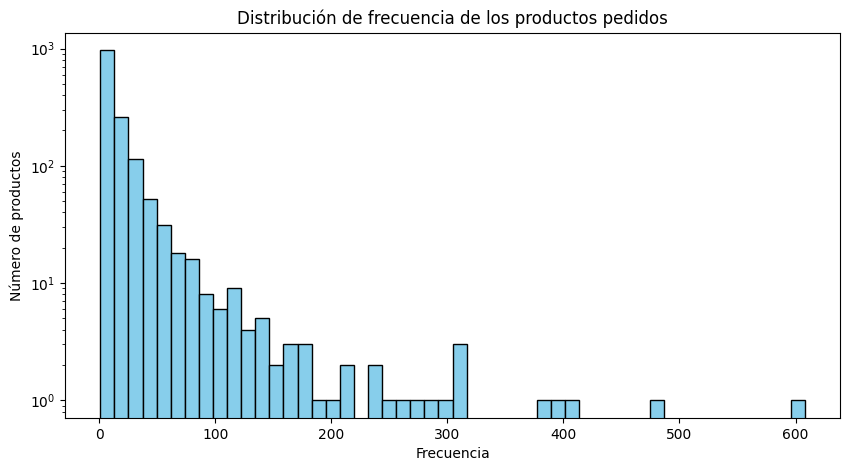

In [206]:
abandoned_carts_products = [item for sublist in abandoned_carts['variant_id'] for item in sublist]
abandoned_carts_products_counter = Counter(abandoned_carts_products)
abandoned_carts_products_counter = pd.DataFrame(abandoned_carts_products_counter.items(), columns=['variant_id', 'count']).sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 5))
plt.hist(abandoned_carts_products_counter['count'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribución de frecuencia de los productos pedidos")
plt.xlabel("Frecuencia")
plt.ylabel("Número de productos")
plt.yscale("log")  
plt.show()


Se ve una distribución muy similar al resto de distribuciones estudiadas. En concreto, hay unos pocos productos que se les abandona con mucha frecuencia.

In [213]:
df_filtered = abandoned_carts_products_counter[abandoned_carts_products_counter['count'] > 300]
for item, descarte in zip(df_filtered['variant_id'], df_filtered['count']):
    count = how_many_times_item_sold(item, orders)
    inventory_item = inventory[inventory['variant_id'] == item]
    if not inventory_item.empty:
        print(f"El producto {item} fue vendido {count} veces y descartado {descarte} veces. Está en el inventario con precio {inventory_item['price'].values[0]}, y tipo de producto: {inventory_item['product_type'].values[0]}.")
    else:
        print(f"El producto {item} fue vendido {count} veces y no está en el inventario.")

El producto 34081589887108 fue vendido 4487 veces y descartado 608 veces. Está en el inventario con precio 10.79, y tipo de producto: long-life-milk-substitutes.
El producto 34284951863428 fue vendido 1133 veces y descartado 478 veces. Está en el inventario con precio 3.69, y tipo de producto: toilet-roll-kitchen-roll-tissue.
El producto 34284950356100 fue vendido 954 veces y descartado 409 veces. Está en el inventario con precio 1.99, y tipo de producto: dishwashing.
El producto 34137590366340 fue vendido 1459 veces y no está en el inventario.
El producto 34284949766276 fue vendido 838 veces y descartado 382 veces. Está en el inventario con precio 8.49, y tipo de producto: toilet-roll-kitchen-roll-tissue.
El producto 34284950519940 fue vendido 551 veces y descartado 307 veces. Está en el inventario con precio 9.99, y tipo de producto: dishwashing.
El producto 34284950454404 fue vendido 683 veces y descartado 306 veces. Está en el inventario con precio 3.99, y tipo de producto: fabric-

Sin cuantificar nada, es obvio ver que los productos que más se descartan son también los más comprados. Habría que intentar estudiar también esta relación. Es decir, si se descarta mucho, se compra mucho. Pero el inverso puede no ser verdad. Puede haber un producto que se venda mucho (entendiéndolo en comparación con el resto) pero que no se descarte casi nunca. Igualmente, la primera afirmación se debe cuantificar de alguna manera.

## Conclusions

1. Tamaño: Hay 5457 carritos abandonados. Esto implica que son carritos que NO se llegaron a comprar, ahora habría que entender si se pueden llegar a comprar en algún momento (lo cual implicaría fijar una fecha, ie , a tal día quedan tantos carritos abiertos) o si fueron completamente descartados (lo cual dejaría carritos en el limbo). Hay 4 variables: id carrito (o pedido), id usuario, lista de pedidos y fecha de creación.
2. No hay duplicados, parece ser que están bien los datos.
3. Parece que hay una correlación entre los productos más descartados y los más vendidos. A priori, muy descartado implica muy vendido, pero no se exploró la inversa aún. 

# Preguntas

### ¿Qué productos se venden más? 

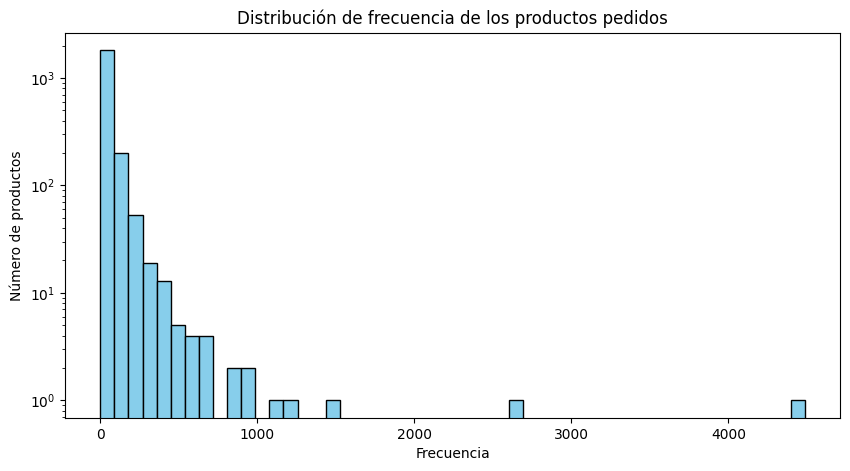

In [111]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

all_items = [item for sublist in orders['ordered_items'] for item in sublist]
item_counts = Counter(all_items)
item_freq_df = pd.DataFrame(item_counts.items(), columns=['variant_id', 'count']).sort_values(by='count', ascending=False)
plt.figure(figsize=(10, 5))
plt.hist(item_freq_df['count'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribución de frecuencia de los productos pedidos")
plt.xlabel("Frecuencia")
plt.ylabel("Número de productos")
plt.yscale("log")  
plt.show()



Parece ser que hay algunos outliers, o productos que son muy demandados. Vamos a obtener una lista de los productos que se han pedido más de 500 veces. Notar que ya hemos visto que no hay duplicados en orders. 

In [112]:
def frequent_items(orders: pd.DataFrame, threshold: int = 500, list_items: bool = False):
    """
    Get items ordered more than a certain threshold.
    """
    all_items = [item for sublist in orders['ordered_items'] for item in sublist]
    item_counts = Counter(all_items)
    frequent_items_threshold = {item: count for item, count in item_counts.items() if count > threshold}
    if list_items:
        for item, count in sorted(frequent_items_threshold.items(), key=lambda x: x[1], reverse=True):
            print(f"{item}: {count}")
    print(f"Hay {len(frequent_items_threshold)} items con más de {threshold} pedidos.")
    return frequent_items_threshold


items_over_100 = frequent_items(orders, threshold=100, list_items=False)
items_over_200 = frequent_items(orders, threshold=200, list_items=False)
items_over_500 = frequent_items(orders, threshold=500, list_items=False)
items_over_1000 = frequent_items(orders, threshold=1000, list_items=False)


Hay 275 items con más de 100 pedidos.
Hay 88 items con más de 200 pedidos.
Hay 19 items con más de 500 pedidos.
Hay 5 items con más de 1000 pedidos.


Vamos a ver por curiosidad qué productos se compraron más de 1000 veces.

In [113]:
ids_over_1000 = list(items_over_1000.keys())
filtered_inventory = inventory[inventory['variant_id'].isin(ids_over_1000)]
print(filtered_inventory)

        variant_id  price  compare_at_price  vendor  \
2   34284951863428   3.69              3.99  plenty   
63  34081589887108  10.79             11.94   oatly   

                       product_type               tags  
2   toilet-roll-kitchen-roll-tissue     [kitchen-roll]  
63       long-life-milk-substitutes  [oat-milk, vegan]  


Hemos encontrado 3 productos que se compran mucho y no están en el inventario. Además, hemos visto que los rollos de cocina y la leche de avena son 2 de los 5 productos que más se compran. Vamos a profundizar en este inciso y ver cuántos de los productos más comprados no aparecen en el inventario. 
Además, la leche de avena es el producto que más se vendió (4487 veces de un total de 8733 pedidos, muy llamativo).

In [153]:
how_many_times_item_sold(34081589887108, orders)

4487

In [117]:
unique_products = set(item for sublist in orders['ordered_items'] for item in sublist)
print(f"Hay {len(unique_products)} productos únicos en los pedidos.")
def products_over_threshold_not_in_inventory(df: pd.DataFrame, inventory: pd.DataFrame, threshold: int = 500):
    """
    Get items ordered more than a certain threshold that are not in the inventory.
    """
    items_over_t= frequent_items(df, threshold=threshold)
    missing_items = set(items_over_t.keys()) - set(inventory['variant_id'].unique())
    print(f"Hay {len(missing_items)} items con más de {threshold} pedidos que no están en el inventario.")

products_over_threshold_not_in_inventory(orders, inventory, threshold=100)
products_over_threshold_not_in_inventory(orders, inventory, threshold=200)
products_over_threshold_not_in_inventory(orders, inventory, threshold=500)
products_over_threshold_not_in_inventory(orders, inventory, threshold=1000)

Hay 2117 productos únicos en los pedidos.
Hay 275 items con más de 100 pedidos.
Hay 19 items con más de 100 pedidos que no están en el inventario.
Hay 88 items con más de 200 pedidos.
Hay 7 items con más de 200 pedidos que no están en el inventario.
Hay 19 items con más de 500 pedidos.
Hay 3 items con más de 500 pedidos que no están en el inventario.
Hay 5 items con más de 1000 pedidos.
Hay 3 items con más de 1000 pedidos que no están en el inventario.


Me falta por seguir explorando, pero no me ha dado tiempo a seguir, paso al siguiente módulo.